In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import trapz
from scipy.stats import binned_statistic
from scipy.special import spherical_jn
import camb

%matplotlib inline

In [2]:
# for plots
import seaborn as sns
sns.set_style("ticks", {'axes.grid': True, 'grid.linestyle': '--'})
sns.set_context("poster")
sns.set_palette("Set2")

In [3]:
# cosmology
pars = camb.CAMBparams()

In [4]:
# planck 2015 TT+lowP+lensing
# https://www.aanda.org/articles/aa/full_html/2016/10/aa25830-15/aa25830-15.html
pars.set_cosmology(ombh2=0.02226, 
                   omch2=0.1186,
                   cosmomc_theta=1.04103/100,
                   H0 = None,
                   tau = 0.066)

pars.InitPower.set_params(ns=0.9677,
                          As=2.139e-9)

pars.set_matter_power(redshifts=[0.3])

#results
results = camb.get_results(pars)

In [5]:
# use these two lines to compare with Planck derived parameters (Table 4 of 2015 parameters
# paper)
# results.get_derived_params()
# results.get_sigma8()

In [6]:
# linear matter power spectrum
kh, z, [pk] = results.get_matter_power_spectrum(npoints=500)

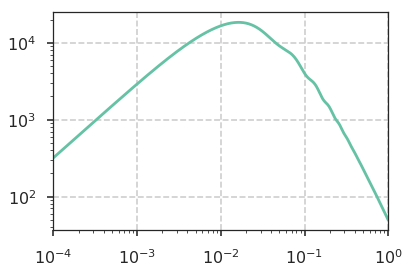

In [7]:
plt.loglog(kh, pk)
plt.xlim(kh.min(),kh.max())
plt.show()

In [13]:
# # correlation function
# def xi(r,k,pk):
#     num = k*pk*np.sin(k*r)
#     den = 2*(np.pi**2)*r
#     integral = trapz(num/den,k)
#     return integral

# correlation function
def xi(r,k,pk):
    num = k**2 * pk* spherical_jn(0,k*r)
    den = 2*(np.pi**2)
    integral = trapz(num,k)
    return integral/den

In [14]:
def xi_binned(r, xi, bin_size=3):
    """r: array of positions to evalue correlation function over"""
    bins = np.arange(r.min(),r.max()+bin_size,bin_size)
    bin_means, bin_edges = binned_statistic(r,xi,statistic='mean',bins=bins)[:2]
    bin_centers = bin_edges[1:] - bin_size/2
    return bin_centers, bin_means

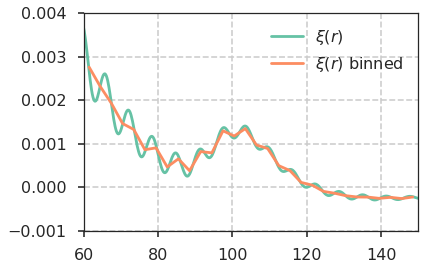

In [15]:
r = np.linspace(60,150,500)
xi_r = [xi(i, kh, pk) for i in r]

plt.plot(r, xi_r, label=r'$\xi(r)$')
plt.plot(*xi_binned(r,xi_r), label=r'$\xi(r)$ binned')

plt.ylim(-0.001,0.004)
plt.xlim(r.min(),r.max())
plt.legend()
plt.show()

In [11]:
# polynomial fit
class Polyfit:
    def __init__(self,order):
        self.order = order
    def do_fit(self, r, xi):
        self.coeffs = np.polyfit(r, xi, self.order)
    def get_fit(self, r):
        return np.dot(r**np.arange(self.order+1)[::-1],self.coeffs)

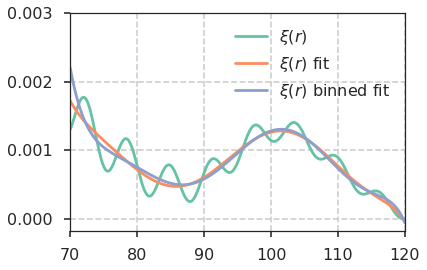

In [12]:
order = 7

# straight from integral
r = np.linspace(70,120,500)
xi_r = [xi(i, kh, pk) for i in r]

# fitting on integral result
pfit = Polyfit(order)
pfit.do_fit(r,xi_r)
xi_fit = [pfit.get_fit(i) for i in r]

# binning integral result
r_bin, xi_bin = xi_binned(r,xi_r)
# fitting on binned data
pfit = Polyfit(order)
pfit.do_fit(r_bin,xi_bin)
xi_fb = [pfit.get_fit(i) for i in r]

plt.plot(r, xi_r, label=r'$\xi(r)$')
plt.plot(r, xi_fit, label=r'$\xi(r)$ fit')
plt.plot(r, xi_fb, label=r'$\xi(r)$ binned fit')


plt.ylim(ymax=0.003)
plt.legend(loc='upper right')
plt.xlim(r.min(),r.max())
plt.show()